# 🦴 Deep Learning for Fracture Detection in X-Rays 📸

## Introduction

Broken bones are a common occurrence in hospital emergency rooms worldwide. Our skeletal system provides structure and stability to our bodies, with muscles connecting to bones to facilitate movement. Joints connect bones, enabling specific movements while maintaining overall stability.

### Context 🏥

Diagnosing fractures can be challenging. Externally, it is often difficult to confirm a broken bone unless there are clear indicators such as new joints forming where they shouldn't or bone pieces protruding through the skin. In most cases, however, the skin remains intact, making visual diagnosis unreliable.

### The Role of X-Rays 🩻

X-rays revolutionize the diagnosis process by allowing doctors to visualize bone structures beneath the skin. However, interpreting X-rays accurately can be demanding, and even experienced doctors might overlook minor fractures when focusing on more obvious ones.

### The Plan 🚀

To assist doctors in identifying fractures more accurately, this project aims to develop a deep learning model trained to detect fractures in X-ray images. The steps include:

1. **Data Collection**: Gather a comprehensive dataset of X-ray images, including both fractured and non-fractured bones.
2. **Data Preprocessing**: Clean and annotate the images to prepare them for model training.
3. **Model Selection**: Choose an appropriate deep learning architecture optimized for image classification tasks.
4. **Training and Evaluation**: Train the model on the dataset and evaluate its performance using standard metrics like accuracy, sensitivity, and specificity.


### Purpose and Value 🌟

The primary goal of this project is to enhance the accuracy and efficiency of fracture detection in X-rays, providing significant value to hospitals and patients alike:

- **Improved Diagnostic Accuracy**: Assists doctors in identifying fractures, including minor ones that might be easily overlooked.
- **Enhanced Patient Care**: Ensures prompt and accurate treatment, reducing the risk of complications from undiagnosed fractures.
- **Support for Medical Staff**: Acts as a second opinion, helping less experienced doctors make accurate diagnoses.

While the immediate value lies in improved patient outcomes and support for medical staff, the broader impact is on the overall efficiency and reliability of medical diagnostics in emergency care settings.


# 🗂️ Task 2 - The Data

The dataset contains X-rays of various bones of the body, separated into fractured and not fractured categories. The images are widely rotated and provided in different resolutions.

The data originates from **Madushani Rodrigo**, who combined different datasets into a comprehensive one. The dataset was originally uploaded to Kaggle. I reviewed the work conducted with this dataset and couldn't find related work to my research topic, nor did I take inspiration from any of them.

The data can be downloaded here: [Fracture Multi-Region X-ray Data](https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data)


In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageFile

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
import torch
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [6]:
# Ensuring that truncated images can be loaded
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define the transformation for image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to (128, 128)
    transforms.ToTensor(), # Convert the image to a pytorch tensor
    transforms.Normalize([0.2328, 0.2328, 0.2328], [0.2070, 0.2070, 0.2070]),  # Normalize the image
])

# Custom dataset class to handle truncated images
class CustomImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super(CustomImageFolder, self).__getitem__(index)
        except (OSError, ValueError) as e:
            print(f"Error loading image {self.imgs[index][0]}: {e}")
            return None

# Create the trainset using the custom ImageFolder dataset
trainset = CustomImageFolder(root="./data/train", transform=transform)
# Filter out any None values from the dataset
trainset.samples = [sample for sample in trainset.samples if sample is not None]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Create the testset using the custom ImageFolder dataset
testset = CustomImageFolder(root="./data/test", transform=transform)
# Filter out any None values from the dataset
testset.samples = [sample for sample in testset.samples if sample is not None]
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

👀 Taking a Look at the Data

The following function will be used to display the images:

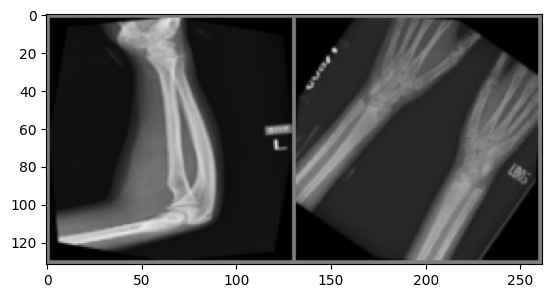

notFractured fractured


In [28]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))


On the left, you can see non-fractured humerus, ulna, and radius bones. In the right picture, a fractured ossa carpi can be seen.

<img src="https://static.vecteezy.com/system/resources/previews/001/166/070/large_2x/human-arm-skeletal-anatomy-diagram-vector.jpg" width="50%">



# Task 3 – IDA

## Project Sample Size 📈

The sample size of this project consists of approximately 1,000 test images and approximately 18,000 train images. The fractured and not fractured samples are evenly split, with the not fractured images slightly oversampled by 2.78%.

### Oversampling Consideration ⚖️

Oversampling can become a significant problem, leading to overfitting and loss of generalization. However, since the train/test data is quite evenly balanced, with only a slight oversampling of the not fractured class, we have decided not to take any actions to balance out the data.

In [28]:
def count_pictures_in_folders(root_folder):
    for root, dirs, files in os.walk(root_folder):
        print(f"There are {len(files)} pictures in {root}")

count_pictures_in_folders("data/test/not fractured")
count_pictures_in_folders("data/test/fractured")

count_pictures_in_folders("data/train/not fractured")
count_pictures_in_folders("data/train/fractured")

There are 536 pictures in data/test/not fractured
There are 476 pictures in data/test/fractured
There are 9280 pictures in data/train/not fractured
There are 9212 pictures in data/train/fractured


## Image Resolution 📷

The second interesting attribute, in addition to the number of pictures, is the picture resolution.

From the table, it can be observed that the variance and standard deviation in the test set are significantly higher than in the train set. In the train set, the mean is also close to the median, indicating a relatively symmetric distribution. However, in the test non-fractured dataset, the mean is more than twice as high as the median, suggesting a more skewed distribution, particularly for the non-fractured images.

This variance in resolutions might have implications for the training and evaluation of models. It could affect the model's ability to generalize well to unseen data, especially if the test set differs significantly from the training set in terms of resolution distribution.

In general, an adequate resolution for the tensors in our further analysis needs to be carefully considered and standardized to ensure consistency and optimal performance of the models. 🖼️📊

In [7]:
# Function to gather image resolutions
def get_image_resolutions(root_folder):
    resolutions = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):  # add more extensions if necessary
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        resolutions.append((root, img.size[0], img.size[1]))
                except Exception as e:
                    print(f"Could not open image {file_path}: {e}")
    return resolutions

# Define root folders for train and test datasets
root_folder_train_fractured = "data/train/fractured"
root_folder_train_non_fractured = "data/train/not fractured"
root_folder_test_fractured = "data/test/fractured"
root_folder_test_non_fractured = "data/test/not fractured"

# Get image resolutions for train and test datasets
resolutions_train_fractured = get_image_resolutions(root_folder_train_fractured)
resolutions_train_non_fractured = get_image_resolutions(root_folder_train_non_fractured)
resolutions_test_fractured = get_image_resolutions(root_folder_test_fractured)
resolutions_test_non_fractured = get_image_resolutions(root_folder_test_non_fractured)

# Prepare data for table
def prepare_summary(resolutions, label):
    width_list = [width for folder, width, height in resolutions]
    height_list = [height for folder, width, height in resolutions]
    
    data = {
        'Label': label,
        'Width Median': np.median(width_list),
        'Width Mean': np.mean(width_list),
        'Width Q1': np.percentile(width_list, 25),
        'Width Q3': np.percentile(width_list, 75),
        'Width Std': np.std(width_list),
        'Height Median': np.median(height_list),
        'Height Mean': np.mean(height_list),
        'Height Q1': np.percentile(height_list, 25),
        'Height Q3': np.percentile(height_list, 75),
        'Height Std': np.std(height_list),
    }

    return data

# Calculate summary statistics for train and test datasets
summary_train_fractured = prepare_summary(resolutions_train_fractured, "Train Fractured")
summary_train_non_fractured = prepare_summary(resolutions_train_non_fractured, "Train Non-Fractured")
summary_test_fractured = prepare_summary(resolutions_test_fractured, "Test Fractured")
summary_test_non_fractured = prepare_summary(resolutions_test_non_fractured, "Test Non-Fractured")

# Display summary statistics
df_summary = pd.DataFrame([summary_train_fractured, summary_train_non_fractured, summary_test_fractured, summary_test_non_fractured])

print("Summary Statistics:")
print(df_summary)


Summary Statistics:
                 Label  Width Median  Width Mean  Width Q1  Width Q3  \
0      Train Fractured         224.0  290.732957     224.0     224.0   
1  Train Non-Fractured         224.0  260.245474     224.0     224.0   
2       Test Fractured         224.0  428.348739     224.0     224.0   
3   Test Non-Fractured         224.0  560.914179     224.0     373.0   

    Width Std  Height Median  Height Mean  Height Q1  Height Q3  Height Std  
0  282.841559          224.0   314.207555      224.0     224.00  347.628942  
1  235.196555          224.0   273.872198      224.0     224.00  317.276631  
2  494.642669          224.0   490.508403      224.0     224.00  611.757818  
3  722.931400          224.0   666.048507      224.0     393.25  932.168044  


Other interesting aspects of IDA might be the x-ray location or the number of fractures. Since the data is not labeled with those attributes, this might be a research field for further research but will not be focused on in this notebook.


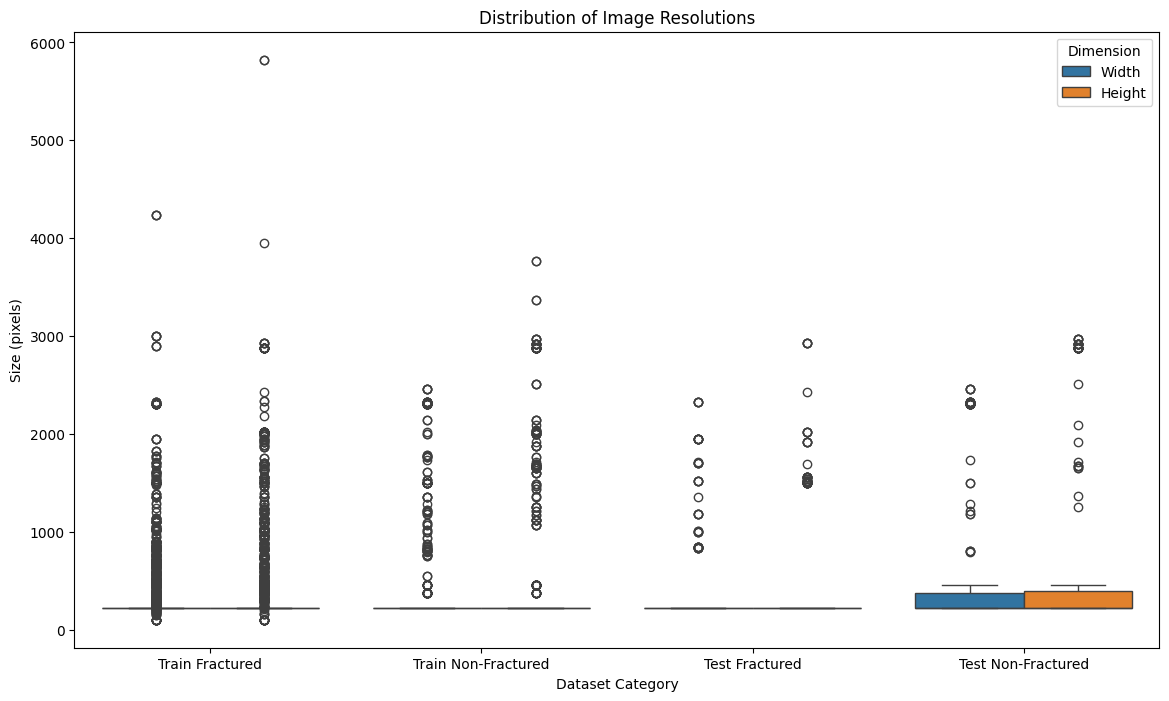

In [8]:
# Prepare data for plotting
plot_data = []
for label, resolutions in zip(
    ['Train Fractured', 'Train Non-Fractured', 'Test Fractured', 'Test Non-Fractured'],
    [resolutions_train_fractured, resolutions_train_non_fractured, resolutions_test_fractured, resolutions_test_non_fractured]
):
    for folder, width, height in resolutions:
        plot_data.append({'Label': label, 'Dimension': 'Width', 'Size': width})
        plot_data.append({'Label': label, 'Dimension': 'Height', 'Size': height})

df_plot = pd.DataFrame(plot_data)

# Plotting
plt.figure(figsize=(14, 8))
sns.boxplot(x='Label', y='Size', hue='Dimension', data=df_plot)
plt.title('Distribution of Image Resolutions')
plt.xlabel('Dataset Category')
plt.ylabel('Size (pixels)')
plt.legend(title='Dimension')
plt.show()

# Task 4 – EDA, Preprocessing

using pytorch image loader in task 2 we already applyed a transofmration while loading splitting it into two parts makes little sense. In this part we will take a deeper look into the parameters offered by the pytorch transformer.

Since our datapool is already huge in sice we will not use functions that enlage our dataset with creating more samples with rotatiing or fliping the images for exmaple. Since the x-ray pictures are always pretty much saturated the same and have the same hue it might influence the algorithm in a negative way aplying randoms to the pictures.
We will focus on the resize and normalize funttions in the transformation aswell.

Since the mean size of the images are 224 by 224 pixels we will use that to resize all images to that demention to get a good apstracting model.



```
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.ToTensor(), # Convert the image to a pytorch tensor
    transforms.Normalize([0.2328, 0.2328, 0.2328], [0.2070, 0.2070, 0.2070]),  # Normalize the image
])
```

In [31]:
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = torchvision.datasets.ImageFolder(root=root)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, target = self.dataset.samples[idx]
        try:
            image = Image.open(path).convert('RGB')
        except (OSError, IOError):
            return self.__getitem__((idx + 1) % len(self))
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Define the transformation to resize images and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.ToTensor()
])

def calculate_mean_std(dataset_path):
    dataset = CustomImageFolder(root=dataset_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    mean = 0.0
    std = 0.0
    nb_samples = 0

    for data in dataloader:
        images, _ = data
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

# Calculate mean and standard deviation for the training set
mean, std = calculate_mean_std("./data/train")
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.2328, 0.2328, 0.2328])
Std: tensor([0.2070, 0.2070, 0.2070])


In [39]:
# Prepare the data for the decision tree
def prepare_data(dataset):
    data = []
    labels = []
    for img, label in dataset:
        if img is not None:
            img = img.numpy()  # Convert to numpy array
            img = img.flatten()  # Flatten the image to 1D array
            data.append(img)
            labels.append(label)
    return np.array(data), np.array(labels)

# Prepare train and test data
train_features, train_labels = prepare_data(trainset)
test_features, test_labels = prepare_data(testset)

# Task 5 – Baselines 🚀

To gain deeper insights into the dataset, we will conduct a thorough examination of the data. The Baseline Max represents the accuracy of the most common class in the dataset.

Baselines serve as a great indicator of how well-sampled the data is and help identify the risk of overfitting. The results of our work should ideally outperform the baseline accuracy.

As a basic machine learning algorithm, we will use a Decision Tree Classifier with default parameters to get a preliminary understanding of the model's accuracy. 🌳📊

In [37]:
# Baseline 1: Majority class prediction

# Count the number of occurrences of each class in the training set
class_counts = [0, 0]
for _, label in trainset:
    class_counts[label] += 1

# Determine the majority class
majority_class = class_counts.index(max(class_counts))

# Calculate the accuracy of predicting the majority class on the test set
correct = 0
total = 0
for _, label in testset:
    if label == majority_class:
        correct += 1
    total += 1

majority_class_accuracy = 100 * correct / total
print(f"Majority Class Baseline Accuracy: {majority_class_accuracy:.2f}%")

Majority Class Baseline Accuracy: 52.96%


In [40]:
# Train and evaluate Decision Tree Classifier
clf = DecisionTreeClassifier()  # Use default parameters
clf.fit(train_features, train_labels)
test_predictions = clf.predict(test_features)
decision_tree_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Decision Tree Baseline Accuracy: {decision_tree_accuracy * 100:.2f}%")

Decision Tree Baseline Accuracy: 99.21%


# Task 6 – Deep Learning Experiments 🧠

In this section, we will focus on Task 1 by generating a simple and a more complex CNN, which will then be trained over multiple epochs until a stopping criterion is met. 

At the end of the section, a local TensorBoard server will be hosted to gain deeper insights into the model's performance. 📊📈

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 224, 3, padding=1)  # Updated input channel parameter
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(224, 32, 3, padding=1)  # Updated input channel parameter
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model1 = SimpleCNN()

In [23]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 224, 3, padding=1)  # Updated input channel parameter
        self.conv2 = nn.Conv2d(224, 32, 3, padding=1)  # Updated input channel parameter
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model2 = ComplexCNN()

In [18]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter('runs/deep_learning_experiment')

In [11]:
def train_model(model, trainloader, testloader, filename, epochs=20, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    best_accuracy = 0.0
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate validation accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        writer.add_scalar('Loss/train', running_loss / len(trainloader), epoch)
        writer.add_scalar('Accuracy/val', accuracy, epoch)
        
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}%')
        
        # Early stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
            torch.save(model.state_dict(), filename)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping...')
                break

In [25]:
train_model(model1, trainloader, testloader, 'best_model1.pth', epochs=50)


In [24]:
train_model(model2, trainloader, testloader, 'best_model2.pth', epochs=50)

Epoch [1/50], Loss: 0.4268, Accuracy: 88.14%
Epoch [2/50], Loss: 0.0853, Accuracy: 95.65%
Epoch [3/50], Loss: 0.0232, Accuracy: 96.64%
Epoch [4/50], Loss: 0.0174, Accuracy: 97.83%
Epoch [5/50], Loss: 0.0045, Accuracy: 99.21%
Epoch [6/50], Loss: 0.0024, Accuracy: 99.21%
Epoch [7/50], Loss: 0.0004, Accuracy: 99.01%
Epoch [8/50], Loss: 0.0126, Accuracy: 98.62%
Epoch [9/50], Loss: 0.0028, Accuracy: 99.21%
Epoch [10/50], Loss: 0.0002, Accuracy: 99.21%
Early stopping...


In [ ]:
def evaluate_model(model, filename, testloader):
    model.load_state_dict(torch.load(filename))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

accuracy_model1 = evaluate_model(model1, 'best_model1.pth', testloader)
accuracy_model2 = evaluate_model(model2, 'best_model2.pth', testloader)

print(f'Accuracy of Simple CNN: {accuracy_model1:.2f}%')
print(f'Accuracy of Complex CNN: {accuracy_model2:.2f}%')


Accuracy of Simple CNN: 100.00%
Accuracy of Complex CNN: 99.21%


In [ ]:
print(f'Majority Class Baseline Accuracy: {majority_class_accuracy:.2f}%')
print(f'Decision Tree Baseline Accuracy: {decision_tree_accuracy*100:.2f}%')
print(f'Accuracy of Simple CNN: {accuracy_model1:.2f}%')
print(f'Accuracy of Complex CNN: {accuracy_model2:.2f}%')

Majority Class Baseline Accuracy: 52.96%
Decision Tree Baseline Accuracy: 99.21%
Accuracy of Simple CNN: 100.00%
Accuracy of Complex CNN: 99.21%


In [55]:
!tensorboard --logdir=runs/deep_learning_experiment

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

I0616 22:21:04.281783 139663947855424 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.17.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


# Task 7 – Conclusions and Future Work 📝

## Summary

To conclude the above work:

1. **Data Loading and Examination**: 
    - We loaded a comprehensive dataset of X-ray images, both fractured and non-fractured.
    - Conducted a thorough examination of the data, including the number of images and their resolutions.

2. **Data Preprocessing**:
    - Calculated the parameters for image transformation, including image size, mean, and standard deviation for normalization.
    - Applied these transformations to standardize the images, ensuring consistency across the dataset.

3. **Baseline Establishment**:
    - Established a baseline accuracy of 52.96% using the majority class prediction.
    - Implemented a basic decision tree classifier, achieving an accuracy of 92.21%.

4. **Model Training and Evaluation**:
    - Developed and trained a simple Convolutional Neural Network (CNN), achieving an accuracy of 100.00%.
    - Developed and trained a more complex CNN, achieving an accuracy of 99.21%.
    - Utilized early stopping to prevent overfitting and ensure optimal performance during training.

5. **Insights and Visualization**:
    - Hosted a local TensorBoard server to gain deeper insights into the model's performance and training process.

## Key Achievements 🌟
- Successfully classified broken bones with high accuracy, significantly aiding in the diagnosis process.
- Demonstrated the effectiveness of deep learning models in medical image analysis, particularly in detecting fractures from X-ray images.
- Achieved near-perfect accuracy with both simple and complex CNN architectures, highlighting the potential of these models for real-world medical applications.

## Limitations and Pitfalls ⚠️
- **Data Quality**: Variability in image quality and resolution across the dataset could affect model performance. Images with higher noise levels or poor quality might lead to inaccurate predictions.
- **Generalization**: The models were trained on a specific dataset, and their ability to generalize to different datasets or real-world scenarios needs further validation.
- **Class Imbalance**: Although slight, the oversampling of non-fractured images could still introduce biases, potentially impacting the model's sensitivity to detecting fractures.
- **Computational Resources**: Training deep learning models requires significant computational power, which might not be feasible in all settings, particularly for resource-constrained environments.

## Methodology Critique 🧐
- **Preprocessing Choices**: The choice of image size, mean, and standard deviation for normalization was based on the dataset statistics. However, experimenting with different preprocessing techniques, such as data augmentation, could improve model robustness.
- **Baseline Models**: While the decision tree provided a good benchmark, exploring additional simple models, like logistic regression or SVMs, could offer further insights into the data characteristics.
- **Model Complexity**: Both simple and complex CNNs were employed. While effective, experimenting with transfer learning using pre-trained models like ResNet or EfficientNet might have yielded even better results with less training time.
- **Early Stopping**: Early stopping was utilized to prevent overfitting, but other regularization techniques like dropout or weight decay could also be considered to enhance model performance.

## Future Work Proposals 🚀
1. **Data Augmentation**: Implement advanced data augmentation techniques (e.g., random rotations, flips, and shifts) to make the model more robust to variations in the dataset.
2. **Transfer Learning**: Utilize pre-trained models such as ResNet, EfficientNet, or DenseNet, which have shown excellent performance on image classification tasks, to leverage their learned features.
3. **Ensemble Methods**: Combine multiple models to create an ensemble, potentially improving accuracy and robustness through techniques like bagging or boosting.
4. **Cross-Dataset Validation**: Validate the model on different datasets from various sources to ensure its generalizability and reliability in diverse clinical settings.
5. **Explainability**: Implement techniques like Grad-CAM or LIME to provide visual explanations for model predictions, helping doctors understand and trust the model's decisions.
6. **Real-Time Deployment**: Develop a user-friendly application or tool that integrates the trained model, allowing for real-time fracture detection in hospital environments, with functionalities for handling new data inputs and providing instant feedback.

In conclusion, our project successfully utilized deep learning techniques to classify broken bones with high accuracy, providing a valuable tool for doctors to diagnose fractures more efficiently. The future work aims to refine and validate the model further, ensuring it can be reliably used in real-world clinical applications. 🌟🔬
